In [1]:
# allow modules to be reloaded
%load_ext autoreload
%autoreload 2

import os
os.chdir("/home/dsseara/git/sociohydro/sim/meanField/fvm")
import matplotlib.pyplot as plt
from matplotlib import animation, rc, collections
import matplotlib as mpl
from IPython.display import HTML
from scipy import interpolate
from fipy.tools.dump import write, read
from fipy.tools import numerix as nx
from shapely import geometry
from fvm_utils import *
from tobler.area_weighted import area_interpolate
from glob import glob
import json

# Simulation test run

In [23]:
! bash run_Schelling2D2S_geographicArea.sh

^C
ERROR:fipy:Uncaught exception:
Traceback (most recent call last):
  File "/home/dsseara/git/sociohydro/sim/meanField/fvm/run_Schelling2D2S_geographicArea.py", line 10, in <module>
    from fvm_utils import *
  File "/home/dsseara/git/sociohydro/sim/meanField/fvm/fvm_utils.py", line 3, in <module>
    import geopandas as gpd
  File "/project/vitelli/dsseara/anaconda/fipy+pytorch/lib/python3.12/site-packages/geopandas/__init__.py", line 3, in <module>
    from geopandas.geoseries import GeoSeries
  File "/project/vitelli/dsseara/anaconda/fipy+pytorch/lib/python3.12/site-packages/geopandas/geoseries.py", line 9, in <module>
    import pandas as pd
  File "/project/vitelli/dsseara/anaconda/fipy+pytorch/lib/python3.12/site-packages/pandas/__init__.py", line 49, in <module>
    from pandas.core.api import (
  File "/project/vitelli/dsseara/anaconda/fipy+pytorch/lib/python3.12/site-packages/pandas/core/api.py", line 46, in <module>
    from pandas.core.flags import Flags
  File "<frozen im

In [15]:
savefolder = "/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro/2024-05-03_fipyTest"
filename = "data.hdf5"
with h5py.File(os.path.join(savefolder, filename), "r") as d:
    cell_centers = d["common"]["cell_centers"][()]
    ϕW_init = d["common"]["phiW_initial"][()]
    ϕB_init = d["common"]["phiB_initial"][()]
    ϕW_final = d["common"]["phiW_final"][()]
    ϕB_final = d["common"]["phiB_final"][()]
    nt = len(list(d.keys())) - 1

    # print(list(d.keys()).contains("n)"))
    # ϕW = d["phiW_array"][()]
    # ϕB = d["phiB_array"][()]
    # ϕW_2020 = d["phiW_2020"][()]
    # ϕB_2020 = d["phiB_2020"][()]
    # t = d["t_array"][()]

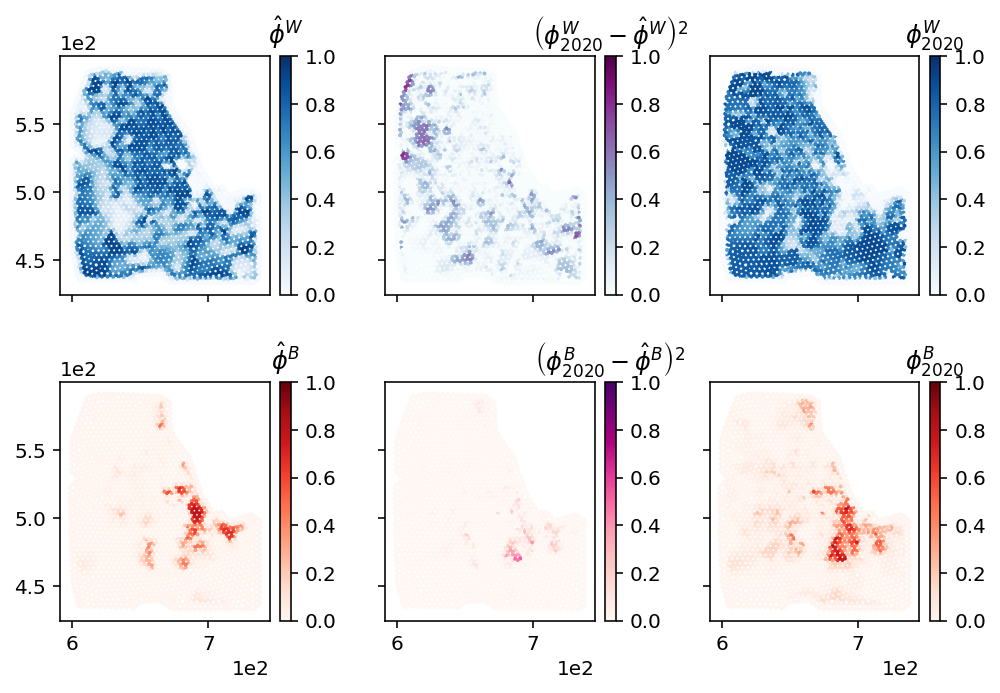

In [16]:
fig, ax = plt.subplots(2, 3, dpi=144, figsize=(7, 5), sharey=True, sharex=True)

for a in ax.ravel(): 
    a.set_aspect(1)
    a.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

# initialize plot

### White population ###
# simulation
cw = ax[0, 0].scatter(cell_centers[:, 0], cell_centers[:, 1], c=ϕW_init,
                      s=1, cmap="Blues", vmin=0, vmax=1)
caxw = ax[0, 0].inset_axes([1.05, 0.0, 0.05, 1])
cbarw = fig.colorbar(cw, ax=ax[0, 0], cax=caxw)
cbarw.ax.set(title=r"$\hat{\phi}^W$")

# error between simulation and final
cw_error = ax[0, 1].scatter(cell_centers[:, 0], cell_centers[:, 1], c=(ϕW_init - ϕW_final)**2,
                            s=1, cmap="BuPu", vmin=0, vmax=1)
caxw_error = ax[0, 1].inset_axes([1.05, 0.0, 0.05, 1])
cbarw_error = fig.colorbar(cw_error, ax=ax[0, 1], cax=caxw_error)
cbarw_error.ax.set(title=r"$\left( \phi^W_\mathrm{2020} - \hat{\phi}^W \right)^2$")

# final population
cw_final = ax[0, 2].scatter(cell_centers[:, 0], cell_centers[:, 1], c=ϕW_final,
                            s=1, cmap="Blues", vmin=0, vmax=1)
caxw_final = ax[0, 2].inset_axes([1.05, 0.0, 0.05, 1])
cbarw_final = fig.colorbar(cw_final, ax=ax[0, 2], cax=caxw_final)
cbarw_final.ax.set(title=r"$\phi^W_\mathrm{2020}$")

### Black population ###
# simulation
cb = ax[1, 0].scatter(cell_centers[:, 0], cell_centers[:, 1], c=ϕB_init,
                      s=1, cmap="Reds", vmin=0, vmax=1)
caxb = ax[1, 0].inset_axes([1.05, 0.0, 0.05, 1])
cbarb = fig.colorbar(cb, ax=ax[1, 0], cax=caxb)
cbarb.ax.set(title=r"$\hat{\phi}^B$")

# error between simulation and final
cb_error = ax[1, 1].scatter(cell_centers[:, 0], cell_centers[:, 1], c=(ϕB_init - ϕB_final)**2,
                            s=1, cmap="RdPu", vmin=0, vmax=1)
caxb_error = ax[1, 1].inset_axes([1.05, 0.0, 0.05, 1])
cbarb_error = fig.colorbar(cb_error, ax=ax[1, 1], cax=caxb_error)
cbarb_error.ax.set(title=r"$\left( \phi^B_\mathrm{2020} - \hat{\phi}^B \right)^2$")

# final population
cb_final = ax[1, 2].scatter(cell_centers[:, 0], cell_centers[:, 1], c=ϕB_final,
                            s=1, cmap="Reds", vmin=0, vmax=1)
caxb_final = ax[1, 2].inset_axes([1.05, 0.0, 0.05, 1])
cbarb_final = fig.colorbar(cb_final, ax=ax[1, 2], cax=caxb_final)
cbarb_final.ax.set(title=r"$\phi^B_\mathrm{2020}$")

plt.tight_layout()

def animate(i):
    with h5py.File(os.path.join(savefolder, filename), "r") as d:
        group = list(d.keys())[i + 1]
        cw.set_array(d[group]["phiW"])
        cb.set_array(d[group]["phiB"])
        cw_error.set_array((d[group]["phiW"] - ϕW_final)**2)
        cb_error.set_array((d[group]["phiB"] - ϕB_final)**2)

    return [cw, cb, cw_error, cb_error]

anim = animation.FuncAnimation(fig, animate, frames=nt, interval=20, blit=True)
# anim.save(f"2024-04-22_T10000_Γ{Γ}.mp4")

HTML(anim.to_html5_video())


In [ ]:
n=0
print(f"n{n:07d}")

In [ ]:
datadict = {"n": 7, "phiB": np.random.randn(100), "phiW": np.random.rand(100)}
for key, value in datadict.items():
    print(value)

In [ ]:
ϕW, ϕB, x, y = get_data("/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5")
x /= 1000
y /= 1000

ξ, _ = get_corrLength("/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5", region="masked",
                      capacity_method="local", p0=[1, 10, 0])

# x /= ξ
# y /= ξ

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
ax[0].pcolormesh(x, y, ϕW, vmin=0, vmax=1, cmap="Blues")
ax[1].pcolormesh(x, y, ϕB, vmin=0, vmax=1, cmap="Reds")
for a in ax.ravel():
    a.set_aspect(1)

ax[0].set(xlabel=r"$x / \xi$", ylabel=r"$y / \xi$")

ax[1].set(xlabel=r"$x / \xi$")

In [ ]:
buffer = 5
simplify = 2
cellsize = 4
crs = "ESRI:102003"
mesh, simple_boundary, geo_file_contents = make_mesh(ϕW, x, y, crs, 
                                                     buffer, simplify, cellsize)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(mesh.cellCenters.value[0], mesh.cellCenters.value[1], s=1)
ax.contour(x, y, np.isnan(ϕW), levels=0)
ax.set_aspect(1)

In [ ]:
fig, ax = plt.subplots(2, 4, dpi=144, sharey=True, sharex=True)

# initial
ax[0, 0].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕW_array[0], s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 0].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕB_array[0], s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 0].set(title="initial", ylabel=r"$\phi^W$")

# final (true)
ax[0, 1].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕWf_cell, s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 1].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕBf_cell, s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 1].set(title="final (true)")

# final (sim)
ax[0, 2].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕW_array[-1], s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 2].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕB_array[-1], s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 2].set(title="final (sim)")

# difference
diffW = ax[0, 3].scatter(mesh.cellCenters.value[0],
                         mesh.cellCenters.value[1],
                         c=(ϕWf_cell - ϕW_array[-1]),
                         s=1, cmap="BrBG", vmin=-1, vmax=1)
caxW = ax[0, 3].inset_axes([1.05, 0.0, 0.05, 1])
cbarW = fig.colorbar(diffW, cax=caxW, ax=ax[0, 3])

diffB = ax[1, 3].scatter(mesh.cellCenters.value[0],
                         mesh.cellCenters.value[1],
                         c=(ϕBf_cell - ϕB_array[-1]),
                         s=1, cmap="BrBG", vmin=-1, vmax=1)
caxB = ax[1, 3].inset_axes([1.05, 0.0, 0.05, 1])
cbarB = fig.colorbar(diffB, cax=caxB, ax=ax[1, 3])


ax[0, 3].set(title="true - sim") 

for a in ax.ravel():
    a.set_aspect(1)
    a.ticklabel_format(axis="both", style="sci", scilimits=(0,0))


ax[1, 0].set(ylabel=r"$\phi^B$")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, 3, dpi=144, sharey=True, sharex=True)

# initial
ax[0, 0].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕW_array[0], s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 0].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕB_array[0], s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 0].set(title="initial", ylabel=r"$\phi^W$")

# final (true)
ax[0, 1].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕWf_cell, s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 1].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕBf_cell, s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 1].set(title="final (true)")

# difference
diffW = ax[0, 2].scatter(mesh.cellCenters.value[0],
                         mesh.cellCenters.value[1],
                         c=ϕWf_cell - ϕW0_cell, s=1,
                         cmap="BrBG")
caxW = ax[0, 2].inset_axes([1.05, 0.0, 0.05, 1])
cbarW = fig.colorbar(diffW, cax=caxW, ax=ax[0, 2])

diffB = ax[1, 2].scatter(mesh.cellCenters.value[0],
                         mesh.cellCenters.value[1],
                         c=ϕBf_cell - ϕB0_cell, s=1,
                         cmap="BrBG")
caxB = ax[1, 2].inset_axes([1.05, 0.0, 0.05, 1])
cbarB = fig.colorbar(diffB, cax=caxB, ax=ax[1, 2])


ax[0, 2].set(title="final - initial") 

for a in ax.ravel():
    a.set_aspect(1)
    a.ticklabel_format(axis="both", style="sci", scilimits=(0,0))


ax[1, 0].set(ylabel=r"$\phi^B$")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
scat0 = ax[0].scatter(cell_points[:, 0], cell_points[:, 1],
                      c=ϕW0_cell + ϕB0_cell, s=1, vmin=0, vmax=1)
scatf = ax[1].scatter(cell_points[:, 0], cell_points[:, 1],
                      c=ϕWf_cell + ϕBf_cell, s=1, vmin=0, vmax=1)
cax = ax[1].inset_axes([1.05, 0.0, 0.05, 1])
cbar = fig.colorbar(scatf, ax=ax[1], cax=cax)
cbar.ax.set(title=r"$\phi^W + \phi^B$")

for a in ax.ravel():
    a.set_aspect(1)
    a.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

In [ ]:
(ϕW0_cell + ϕB0_cell).mean()

In [ ]:
(ϕWf_cell + ϕBf_cell).mean()

# Check interpolation

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
simple_boundary.boundary.plot(ax=ax[0], color="k")
simple_boundary.boundary.plot(ax=ax[1], color="k")
scatW = ax[0].scatter(mesh.cellCenters.value[0],
                      mesh.cellCenters.value[1],
                      c=ϕW0_cell, s=1,
                      cmap="Blues", vmin=0, vmax=1)
cax0 = ax[0].inset_axes([1.05, 0.0, 0.05, 1])
cbar0 = fig.colorbar(scatW, ax=ax[0], cax=cax0)
cbar0.ax.set(title=r"$\phi^W$")
ax[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

scatB = ax[1].scatter(mesh.cellCenters.value[0],
                      mesh.cellCenters.value[1],
                      c=ϕB0_cell, s=1,
                      cmap="Reds", vmin=0, vmax=1)
cax1 = ax[1].inset_axes([1.05, 0.0, 0.05, 1])
cbar1 = fig.colorbar(scatB, ax=ax[1], cax=cax1)
cbar1.ax.set(title=r"$\phi^B$")
ax[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.tight_layout()


# Measure gradient magnitudes

In [ ]:
import h5py

In [ ]:
datafile = "/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5"
with h5py.File(datafile) as d:
    ρW = d["1990"]["white_grid_masked"][()]
    ρB = d["1990"]["black_grid_masked"][()]
    x_grid = d["1990"]["x_grid"][()]
    y_grid = d["1990"]["y_grid"][()]
    
    capacity = np.zeros(x_grid.shape)
    for key in d.keys():
        capacity = np.fmax(capacity, d[key]["white_grid_masked"][:] + d[key]["black_grid_masked"][:])
    
ϕW = ρW / (1.1 * capacity)
ϕB = ρB / (1.1 * capacity)

In [ ]:
fig, ax = plt.subplots(dpi=144, figsize=(3, 3))
ax.pcolormesh(x_grid, y_grid, ϕW, cmap="Blues", vmin=0, vmax=1)
ax.set_aspect(1)
ax.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

In [ ]:
ϕWx, ϕWy = np.gradient(ϕW, 1000, 1000)
print([np.nanmin(ϕWx), np.nanmax(ϕWx)])
print([np.nanmin(ϕWy), np.nanmax(ϕWy)])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=144, sharey=True)
ax[0].pcolormesh(x_grid, y_grid, ϕW, cmap="Blues", vmin=0, vmax=1)
ax[1].pcolormesh(x_grid, y_grid, ϕWx, cmap="BuPu", vmin=-4e-4, vmax=4e-4)
ax[2].pcolormesh(x_grid, y_grid, ϕWy, cmap="BuPu", vmin=-4e-4, vmax=4e-4)
for a in ax.ravel():
    a.ticklabel_format(axis="both", style="sci", scilimits=(0,0))


# look at meshes created

In [2]:
state = "Georgia"
county = "Fulton"
state_county = state + "_" + county

datafile = "/project/vitelli/dsseara/schelling/data/decennial/gridded_small/" + state_county + "_small.hdf5"
sigma = 2.0

# parameters for meshing
capacityType = "local"
buffer = 1
simplify = 1
cellsize = 3


In [3]:
# datafile = os.path.join(savefolder, filename + ".hdf5")
# paramfile = os.path.join(savefolder, filename + "_params.json")
ϕW0, ϕB0, x, y = get_data(datafile,
                          year=1990,
                          region="masked",
                          capacity_method=capacityType)
Wnans = np.isnan(ϕW0)
Bnans = np.isnan(ϕB0)
ϕW0 = ndimage.gaussian_filter(np.nan_to_num(ϕW0), sigma)
ϕW0[Wnans] = np.nan
ϕB0 = ndimage.gaussian_filter(np.nan_to_num(ϕB0), sigma)
ϕB0[Bnans] = np.nan
x /= 1000.0
y /= 1000.0

In [4]:
crs = "ESRI:102003"  # all cases fall into this CRS
mesh, simple_boundary, geo_file_contents = make_mesh(ϕW0, x, y, crs,
                                                     buffer,
                                                     simplify,
                                                     cellsize)

In [5]:
ϕW = fp.CellVariable(name="phiW", mesh=mesh, hasOld=True)
ϕB = fp.CellVariable(name="phiB", mesh=mesh, hasOld=True)
grid_points = np.array([[x, y] for x, y in zip(x.ravel(),
                                               y.ravel())])
cell_points = np.array([[x, y] for x, y in zip(mesh.cellCenters.value[0],
                                               mesh.cellCenters.value[1])])
ϕW0_cell = interpolate.griddata(grid_points,
                                np.nan_to_num(ϕW0.ravel(), nan=1e-3),
                                cell_points,
                                fill_value=1e-3)
ϕB0_cell = interpolate.griddata(grid_points,
                                np.nan_to_num(ϕB0.ravel(), nan=1e-3),
                                cell_points,
                                fill_value=1e-3)
ϕW[:] = ϕW0_cell
ϕB[:] = ϕB0_cell


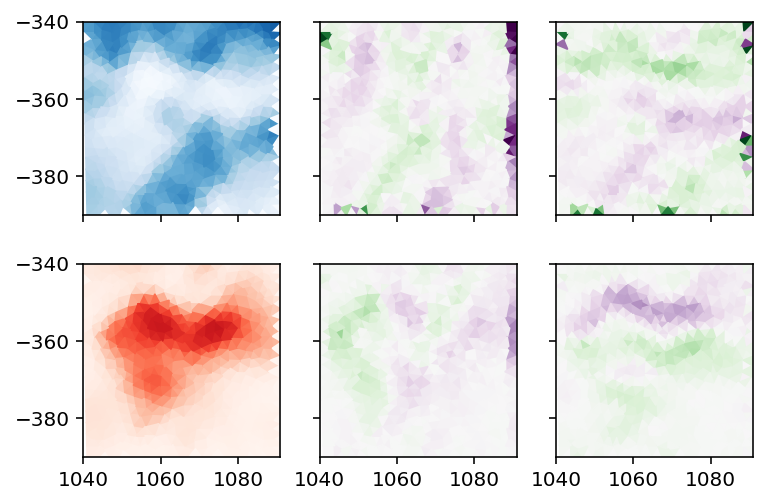

In [6]:
fig, (axW, axB) = plt.subplots(2, 3, dpi=144, figsize=(6,4),
                               sharey=True, sharex=True)

plot_mesh(ϕW, mesh, axW[0],
          cmap=plt.cm.Blues, vmin=0, vmax=1)
plot_mesh(ϕW.grad.value[0], mesh, axW[1],
          cmap=plt.cm.PRGn, vmin=-0.25, vmax=0.25)
plot_mesh(ϕW.grad.value[1], mesh, axW[2],
          cmap=plt.cm.PRGn, vmin=-0.25, vmax=0.25)

plot_mesh(ϕB, mesh, axB[0],
          cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(ϕB.grad.value[0], mesh, axB[1],
          cmap=plt.cm.PRGn, vmin=-0.25, vmax=0.25)
plot_mesh(ϕB.grad.value[1], mesh, axB[2],
          cmap=plt.cm.PRGn, vmin=-0.25, vmax=0.25)



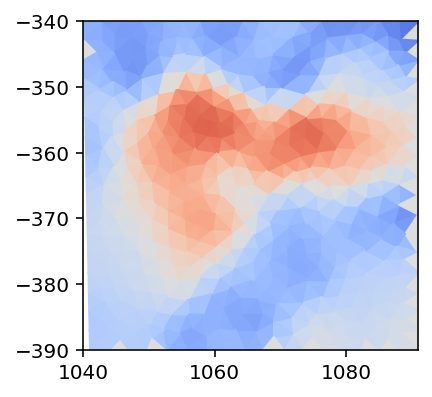

In [7]:
fig, ax = plt.subplots(dpi=144, figsize=(3,3))

plot_mesh(ϕW-ϕB, mesh, ax, cmap=plt.cm.coolwarm_r,
          vmin=-1, vmax=1)


In [21]:
write([ϕW, ϕB], "test.fipy")

In [22]:
ϕW_read, ϕB_read = read("test.fipy")

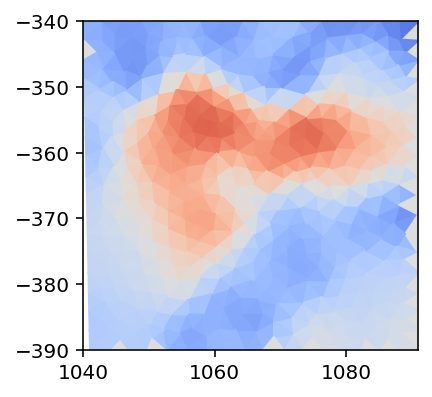

In [25]:
fig, ax = plt.subplots(dpi=144, figsize=(3,3))

plot_mesh(ϕW_read-ϕB_read, ϕW_read.mesh, ax,
          cmap=plt.cm.coolwarm_r,
          vmin=-1, vmax=1)


In [32]:
ρ = fp.CellVariable(name="rho", mesh=mesh)

True

# do area-weighted interpolation from grid to mesh

In [6]:
use_fill_frac = False
use_max_scaling = True
state_county = "Illinois_Cook"

inferenceFolder = "/project/vitelli/dsseara/schelling/inference/2024-12-17_censusLinearRegression/data"
foldername = f"{state_county}_fillFrac{str(use_fill_frac)}_relDen{str(use_max_scaling)}"
folder = os.path.join(inferenceFolder, foldername)

paramfile = glob(os.path.join(folder, "*.json"))[0]
with open(paramfile, "r") as f:
    params = json.load(f)

In [7]:
datafile = os.path.join(params["datafolder"], f"{state_county}.hdf5")
sigma = params["sigma"]

wb, x, y, t, housing, mask = get_data(datafile,
                                      spatial_scale=1000,
                                      sigma=sigma,
                                      use_fill_frac=use_fill_frac,
                                      use_max_scaling=use_max_scaling)

wb0 = wb(1990)
wbf = wb(2020)
crs = "ESRI:102003"
buffer = 1
simplify = 1
cellsize = 3

In [8]:
dx = x[1, 1] - x[0, 0]
dy = y[1, 1] - y[0, 0]
ny, nx = x.shape
grid = fp.Grid2D(dx=dx, dy=dy, nx=nx, ny=ny) + ((x.min(), ), (y.min(), ))

# put all data into geodataframes
grid_gdf = mesh_to_gdf(grid, crs=crs)
if use_max_scaling:
    max_housing = housing[mask].max()
    grid_gdf["w0"]  = (wb0[0] * max_housing).ravel()
    grid_gdf["wf"]  = (wbf[0] * max_housing).ravel()
    grid_gdf["b0"]  = (wb0[1] * max_housing).ravel()
    grid_gdf["bf"]  = (wbf[1] * max_housing).ravel()
elif use_fill_frac:
    grid_gdf["w0"]  = (wb0[0] * housing).ravel()
    grid_gdf["wf"]  = (wbf[0] * housing).ravel()
    grid_gdf["b0"]  = (wb0[1] * housing).ravel()
    grid_gdf["bf"]  = (wbf[1] * housing).ravel()

grid_gdf["housing"] = housing.ravel()
grid_gdf["mask"] = mask.astype(int).ravel()

# create mesh
mesh, simple_boundary, geo_file_contents = make_mesh(wb0, x, y, crs,
                                                        buffer,
                                                        simplify,
                                                        cellsize)

mesh_gdf = mesh_to_gdf(mesh, crs=crs)
interp = area_interpolate(grid_gdf, mesh_gdf,
                            extensive_variables=["w0", "wf",
                                                 "b0", "bf",
                                                 "housing"],
                            intensive_variables=["mask"])

if use_fill_frac:
    interp["w0"] /= interp["housing"] * 1.1
    interp["wf"] /= interp["housing"] * 1.1
    interp["b0"] /= interp["housing"] * 1.1
    interp["bf"] /= interp["housing"] * 1.1
    # set fill fractions to zero where housing is zero
    zero_housing = (interp["housing"] == 0).values
    interp.loc[zero_housing, "w0"] = 0
    interp.loc[zero_housing, "wf"] = 0
    interp.loc[zero_housing, "b0"] = 0
    interp.loc[zero_housing, "bf"] = 0
elif use_max_scaling:
    max_housing = interp[interp["mask"] > 0]["housing"].max() * 1.1
    interp["w0"] /= max_housing
    interp["wf"] /= max_housing
    interp["b0"] /= max_housing
    interp["bf"] /= max_housing


/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: w0, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: wf, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: b0, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: bf, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: housing, replacing with

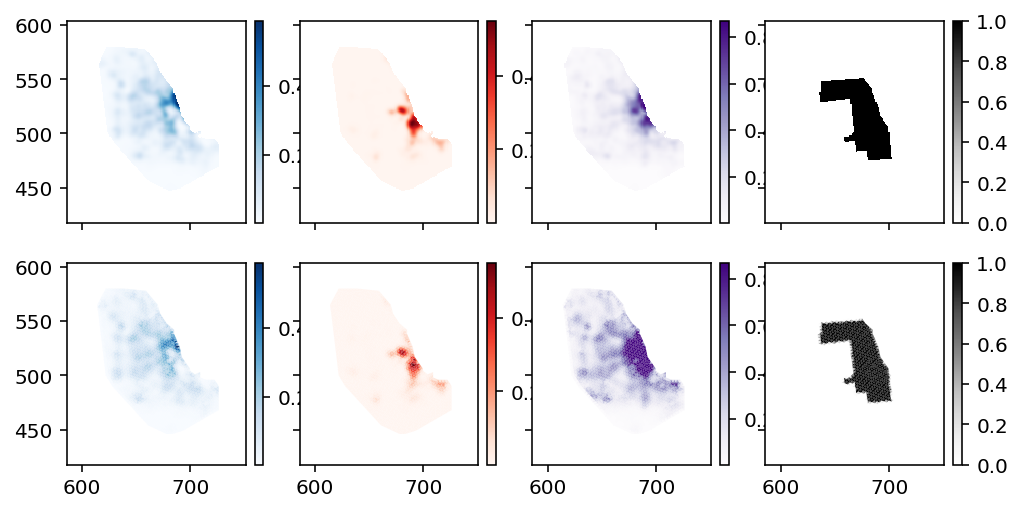

In [9]:
fig, ax = plt.subplots(2, 4, dpi=144, figsize=(8, 4),
                       sharey=True, sharex=True)
for col, (var, cmap) in enumerate(zip(["w0", "b0", "housing", "mask"], 
                                      ["Blues", "Reds", "Purples", "Greys"])):
    vmin = grid_gdf[var].min()
    vmax = grid_gdf[var].max()

    caxg = ax[0, col].inset_axes([1.05, 0.0, 0.05, 1])
    grid_gdf.plot(var, ax=ax[0, col], cmap=cmap,
                  rasterized=True, vmin=vmin, vmax=vmax,
                  legend=True, cax=caxg)
    
    caxi = ax[1, col].inset_axes([1.05, 0.0, 0.05, 1])
    interp.plot(var, ax=ax[1, col], cmap=cmap,
                rasterized=True, vmin=vmin, vmax=vmax,
                legend=True, cax=caxi)


# check why some scripts create small geojson files

specifically, why does the script `run_Schelling2D2S_geographicArea_quadraticUtility_quadraticGrowth.py` give tiny geojson files?

Answer -- sometimes the maps have a single pixel isolated from the rest of the map. In the function `make_boundary`, we have the line:

`grid_boundary = gpd.GeoDataFrame([polygons[0]], geometry=[polygons[0]])`

which assumes that we only have a single polygon. Instead we will work with the polygon with the largest area. This may be the problematic in areas like New York, but whatever.

The relevant line is changed to

`grid_boundary = gpd.GeoDataFrame(geometry=polygons)`

During the buffering/simplification process, any nearby geometries will be unified

In [2]:
# test param set
datafolder = "/project/vitelli/dsseara/schelling/sims/2024-12-26_fipy_linRegParams/data_1e-2/"
paramfile = "California_Contra Costa_fillFracTrue_relDenFalse"
paramfile = "California_Contra Costa_fillFracFalse_relDenTrue"

with open(os.path.join(datafolder, paramfile, f"{paramfile}_params.json"), "r") as f:
    params = json.load(f)

NameError: name 'os' is not defined

In [119]:
wb, x, y, t, housing, mask = get_data(
    params["inputfile"],
    spatial_scale=1000,
    sigma=params["sigma"],
    use_fill_frac=params["use_fill_frac"],
    use_max_scaling=params["use_max_scaling"]
)

wb0 = wb(t.min() + 10)
wbf = wb(t.max())

crs = "ESRI:102003"  # all cases fall into this CRS

# create square mesh
dx = x[1, 1] - x[0, 0]
dy = y[1, 1] - y[0, 0]
ny, nx = x.shape
grid = fp.Grid2D(dx=dx, dy=dy, nx=nx, ny=ny) + ((x.min(), ), (y.min(), ))

# put all data into geodataframes
grid_gdf = mesh_to_gdf(grid, crs=crs)
if params["use_max_scaling"]:
    max_housing = housing[mask].max()
    grid_gdf["w0"]  = (wb0[0] * max_housing).ravel()
    grid_gdf["wf"]  = (wbf[0] * max_housing).ravel()
    grid_gdf["b0"]  = (wb0[1] * max_housing).ravel()
    grid_gdf["bf"]  = (wbf[1] * max_housing).ravel()
elif params["use_fill_frac"]:
    grid_gdf["w0"]  = (wb0[0] * housing).ravel()
    grid_gdf["wf"]  = (wbf[0] * housing).ravel()
    grid_gdf["b0"]  = (wb0[1] * housing).ravel()
    grid_gdf["bf"]  = (wbf[1] * housing).ravel()

grid_gdf["housing"] = housing.ravel()
grid_gdf["mask"] = mask.astype(int).ravel()

# create mesh
mesh, simple_boundary, geo_file_contents = make_mesh(wb0[0], x, y, crs,
                                                     params["buffer"],
                                                     params["simplify"],
                                                     params["cellsize"])

mesh_gdf = mesh_to_gdf(mesh, crs=crs)
interp = area_interpolate(grid_gdf, mesh_gdf,
                        extensive_variables=["w0", "wf", "b0", "bf", "housing"],
                        intensive_variables=["mask"])

# if params["use_fill_frac"]:
#     interp["w0"] /= interp["housing"] * 1.0
#     interp["wf"] /= interp["housing"] * 1.0
#     interp["b0"] /= interp["housing"] * 1.0
#     interp["bf"] /= interp["housing"] * 1.0
#     # set fill fractions to zero where housing is zero
#     zero_housing = (interp["housing"] == 0).values
#     interp.loc[zero_housing, "w0"] = 0
#     interp.loc[zero_housing, "wf"] = 0
#     interp.loc[zero_housing, "b0"] = 0
#     interp.loc[zero_housing, "bf"] = 0
# elif params["use_max_scaling"]:
#     max_housing = interp[interp["mask"] > 0]["housing"].max() * 1.0
#     interp["w0"] /= max_housing
#     interp["wf"] /= max_housing
#     interp["b0"] /= max_housing
#     interp["bf"] /= max_housing

interp.loc[interp["mask"] > 1, "mask"] = 1

/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: w0, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: wf, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: b0, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: bf, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: housing, replacing with

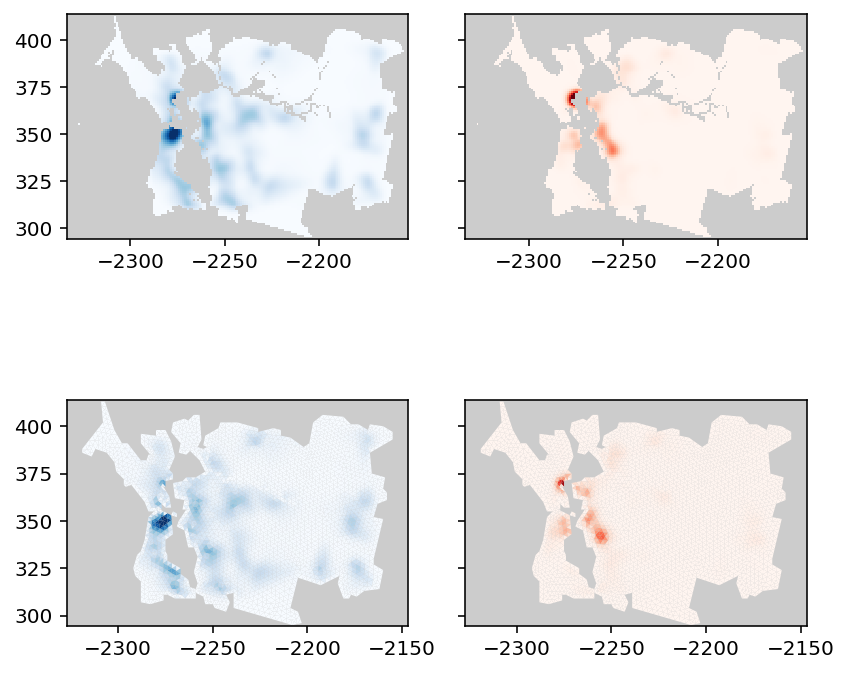

In [120]:
fig, ax = plt.subplots(2, 2, sharey=True, dpi=144, figsize=(6, 6))
ax[0, 0].pcolormesh(x, y, wb0[0], cmap="Blues", vmin=0, vmax=1)
ax[0, 1].pcolormesh(x, y, wb0[1], cmap="Reds", vmin=0, vmax=1)

interp.plot(interp["w0"], ax=ax[1, 0], cmap="Blues", vmin=0, vmax=1)
interp.plot(interp["b0"], ax=ax[1, 1], cmap="Reds", vmin=0, vmax=1)

# make all axes have aspect ratio of 1 and black background
for a in ax.ravel():
    a.set_aspect(1)
    a.set_facecolor("0.8")

plt.tight_layout()

In [2]:
interp["housing"].max()

NameError: name 'interp' is not defined

# check errors when running simulations

| jobid | location | status |
|-------|----------|--------|
| 28553194 | Arizona_Maricopa | ok |
| 28553195 | California_Alameda | mesh |
| 28553196 | California_Contra Costa | mesh |
| 28553197 | California_Los Angeles | ok |
| 28553198 | California_Orange | log |
| 28553199 | California_Riverside | log |
| 28553200 | California_Sacramento | log |
| 28553201 | California_San Bernardino | coefs_mean |
| 28553202 | California_San Diego | log |
| 28553203 | California_Santa Clara | log |
| 28553204 | Florida_Broward | mesh |
| 28553205 | Florida_Dade | coefs_mean |
| 28553206 | Florida_Hillsborough | log |
| 28553207 | Florida_Orange | ok |
| 28553208 | Florida_Palm Beach | log |
| 28553209 | Georgia_Fulton | ok |
| 28553210 | Illinois_Cook | unstable |
| 28553211 | Massachusetts_Middlesex | ok |
| 28553212 | Michigan_Oakland | log |
| 28553213 | Michigan_Wayne | unstable |
| 28553214 | Minnesota_Hennepin | ok |
| 28553215 | Nevada_Clark | ok |
| 28553216 | New York_Bronx | log |
| 28553217 | New York_Kings | log |
| 28553218 | New York_Nassau | log |
| 28553219 | New York_New York | coefs_mean |
| 28553220 | New York_Queens | log |
| 28553221 | New York_Suffolk | mesh |
| 28553222 | Ohio_Cuyahoga | unstable |
| 28553223 | Ohio_Franklin | ok |
| 28553224 | Pennsylvania_Allegheny | ok |
| 28553225 | Pennsylvania_Philadelphia | unstable |
| 28553226 | Texas_Bexar | ok |
| 28553227 | Texas_Dallas | ok |
| 28553228 | Texas_Harris | unstable |
| 28553229 | Texas_Tarrant | log |
| 28553230 | Utah_Salt Lake | ok |
| 28553231 | Virginia_Fairfax | log |
| 28553232 | Washington_King | unstable |

In [2]:
scs = [
    "Arizona_Maricopa",
    "California_Alameda",
    "California_Contra Costa",
    "California_Los Angeles",
    "California_Orange",
    "California_Riverside",
    "California_Sacramento",
    "California_San Bernardino",
    "California_San Diego",
    "California_Santa Clara",
    "Florida_Broward",
    "Florida_Dade",
    "Florida_Hillsborough",
    "Florida_Orange",
    "Florida_Palm Beach",
    "Georgia_Fulton",
    "Illinois_Cook",
    "Massachusetts_Middlesex",
    "Michigan_Oakland",
    "Michigan_Wayne",
    "Minnesota_Hennepin",
    "Nevada_Clark",
    "New York_Bronx",
    "New York_Kings",
    "New York_Nassau",
    "New York_New York",
    "New York_Queens",
    "New York_Suffolk",
    "Ohio_Cuyahoga",
    "Ohio_Franklin",
    "Pennsylvania_Allegheny",
    "Pennsylvania_Philadelphia",
    "Texas_Bexar",
    "Texas_Dallas",
    "Texas_Harris",
    "Texas_Tarrant",
    "Utah_Salt Lake",
    "Virginia_Fairfax",
    "Washington_King"
]

status = [
    "ok", 
    "mesh", 
    "mesh", 
    "ok", 
    "log", 
    "log", 
    "log", 
    "coefs_mean", 
    "log", 
    "log", 
    "mesh", 
    "coefs_mean", 
    "log", 
    "ok", 
    "log", 
    "ok", 
    "unstable", 
    "ok", 
    "log", 
    "unstable", 
    "ok", 
    "ok", 
    "log", 
    "log", 
    "log", 
    "coefs_mean", 
    "log", 
    "mesh", 
    "unstable", 
    "ok", 
    "ok", 
    "unstable", 
    "ok", 
    "ok", 
    "unstable", 
    "log", 
    "ok", 
    "log", 
    "unstable"
]

sc_status = pd.DataFrame({"state_county": scs, "status": status})
sc_problems = sc_status[sc_status["status"] != "ok"]

In [3]:
idx = -4
sc = sc_problems.iloc[idx]["state_county"]
print(sc_problems.iloc[idx])

state_county    Texas_Harris
status              unstable
Name: 34, dtype: object


In [5]:
# fix mesh issues
datafile = f"/project/vitelli/dsseara/schelling/data/decennial/gridded/{sc}.hdf5"
sigma = 3
buffer = 1
simplify = 1
cellsize = 3
use_fill_frac = False
use_max_scaling = True

wb, x, y, t, housing, mask = get_data(datafile,
                                      spatial_scale=1000,
                                      sigma=sigma,
                                      use_fill_frac=use_fill_frac,
                                      use_max_scaling=use_max_scaling)

wb0 = wb(t.min())
wbf = wb(t.max())

# create meshes for interpolation
crs = "ESRI:102003"  # all cases fall into this CRS

# create square mesh
dx = x[1, 1] - x[0, 0]
dy = y[1, 1] - y[0, 0]
# ny, nx = x.shape
grid = fp.Grid2D(dx=dx, dy=dy, nx=x.shape[1], ny=x.shape[0]) + ((x.min(), ), (y.min(), ))

# put all data into geodataframes
grid_gdf = mesh_to_gdf(grid, crs=crs)
if use_max_scaling:
    max_housing = housing[mask].max()
    grid_gdf["w0"]  = (wb0[0] * max_housing).ravel()
    grid_gdf["wf"]  = (wbf[0] * max_housing).ravel()
    grid_gdf["b0"]  = (wb0[1] * max_housing).ravel()
    grid_gdf["bf"]  = (wbf[1] * max_housing).ravel()
elif use_fill_frac:
    grid_gdf["w0"]  = (wb0[0] * housing).ravel()
    grid_gdf["wf"]  = (wbf[0] * housing).ravel()
    grid_gdf["b0"]  = (wb0[1] * housing).ravel()
    grid_gdf["bf"]  = (wbf[1] * housing).ravel()

grid_gdf["housing"] = housing.ravel()
grid_gdf["mask"] = mask.astype(int).ravel()

mesh, simple_boundary, geo_file_contents = make_mesh(wb0[0], x, y, crs=crs,
                                                     buffer=buffer,
                                                     simplify=simplify,
                                                     cellsize=cellsize,
                                                     square=False)


(<matplotlib.collections.PolyCollection at 0x7fa91195e1a0>,
 <matplotlib.colors.Normalize at 0x7fa91197b610>)

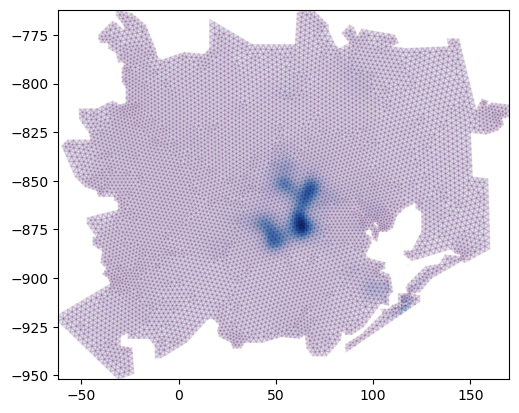

In [8]:
fig, ax = plt.subplots()
ax.pcolormesh(x, y, wb(1990)[1], cmap="Blues")
plot_mesh(np.zeros(mesh.numberOfCells), mesh, ax=ax, alpha=0.1, colorbar=False)

In [9]:
# fix log issues
mesh_gdf = mesh_to_gdf(mesh, crs=crs)
interp = area_interpolate(grid_gdf, mesh_gdf,
                          extensive_variables=["w0", "wf", "b0", "bf", "housing"],
                          intensive_variables=["mask"])

if use_fill_frac:
    interp["w0"] /= interp["housing"] * 1.1
    interp["wf"] /= interp["housing"] * 1.1
    interp["b0"] /= interp["housing"] * 1.1
    interp["bf"] /= interp["housing"] * 1.1
    # set fill fractions to zero where housing is zero
    zero_housing = (interp["housing"] == 0).values
    interp.loc[zero_housing, "w0"] = 0
    interp.loc[zero_housing, "wf"] = 0
    interp.loc[zero_housing, "b0"] = 0
    interp.loc[zero_housing, "bf"] = 0
elif use_max_scaling:
    # max_housing = interp[interp["mask"] > 0]["housing"].max() * 1.1
    max_housing = interp["housing"].max() * 1.1
    interp["w0"] /= max_housing
    interp["wf"] /= max_housing
    interp["b0"] /= max_housing
    interp["bf"] /= max_housing


ϕW = fp.CellVariable(name="phiW", mesh=mesh, hasOld=True)
ϕB = fp.CellVariable(name="phiB", mesh=mesh, hasOld=True)
ϕW.setValue(interp["w0"])
ϕW.setValue(1e-2, where=ϕW<=1e-2)
ϕW.setValue(1-1e-2, where=ϕW>=1-1e-2)
# ϕB[:] = ϕB0_cell
ϕB.setValue(interp["b0"])
ϕB.setValue(1e-2, where=ϕB<=1e-2)
ϕB.setValue(1-1e-2, where=ϕB>=1-1e-2)

ϕ0 = 1 - ϕW - ϕB

nx.log(ϕW)
nx.log(ϕB)
nx.log(ϕ0)

/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: w0, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: wf, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: b0, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: bf, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/tobler/util/util.py:57: UserWarning: nan values in variable: housing, replacing with

log(((1 - phiW) - phiB))

# run simulation forward to see how the system goes unstable

In [23]:
sc = "Texas_Harris"
datafolder = f"/project/vitelli/dsseara/schelling/sims/2024-12-26_fipy_linRegParams/data/sigma3/{sc}_fillFracFalse_relDenTrue"
paramfile = glob(os.path.join(datafolder, "*.json"))[0]
with open(paramfile, "r") as f:
    args = json.load(f)

fipyfiles = sorted(glob(os.path.join(datafolder, "fipy_output", "*")))

w, b, t = read(fipyfiles[-1])

In [24]:
import fipy.tools.numerix as nx

### build simulation ###
# utility parameters
TW   = args["tempW"]
ΓW   = args["gammaW"]
κWW  = args["kWW"]
κWB  = args["kWB"]
νWWW = args["nuWWW"]
νWWB = args["nuWWB"]
νWBB = args["nuWBB"]
rW = args["growthW"]

TB   = args["tempB"]
ΓB   = args["gammaB"]
κBB  = args["kBB"]
κBW  = args["kBW"]
νBBB = args["nuBBB"]
νBWB = args["nuBWB"]
νBWW = args["nuBWW"]
rB = args["growthB"]

# test on different mesh
mesh = w.mesh
# mesh = fp.Grid2D(dx=1, dy=1, nx=100, ny=100)
x = mesh.cellCenters.value[0]
y = mesh.cellCenters.value[1]


ϕW = fp.CellVariable(name=r"phiW",  mesh=mesh, hasOld=True)
μW = fp.CellVariable(name=r"muW",   mesh=mesh, hasOld=True)
ϕB = fp.CellVariable(name=r"phiB",  mesh=mesh, hasOld=True)
μB = fp.CellVariable(name=r"muB",   mesh=mesh, hasOld=True)

ϕW.setValue(w.value)
# ϕW.setValue(1e-2, where=ϕW<=1e-2)
# ϕW.setValue(1-1e-2, where=ϕW>=1-1e-2)
# ϕW.setValue(nx.exp(-((x - x.mean() - 10)**2 + (y - y.mean() - 10)**2)/(2 * 10**2)) * 0.9 + 0.01)

ϕB.setValue(b.value)
# ϕB.setValue(1e-2, where=ϕB<=1e-2)
# ϕB.setValue(1-1e-2, where=ϕB>=1-1e-2)
# ϕB.setValue(nx.exp(-((x - x.mean() + 10)**2 + (y - y.mean() + 10)**2)/(2 * 10**2)) * 0.9 + 0.01)

# ϕ0 = 1 - ϕW - ϕB

mobilityW = ϕW * (1 - ϕW - ϕB)
πW = κWW * ϕW + κWB * ϕB + νWWW * ϕW * ϕW + νWWB * ϕW * ϕB + νWBB * ϕB * ϕB
dπWdϕW = κWW + 2 * νWWW * ϕW + νWWB * ϕB
μW_taylorExpand = -πW + TW * (nx.log(ϕW) - nx.log(1 - ϕW - ϕB))
dμWdϕW = -dπWdϕW + TW * (1 - ϕB) / (ϕW * (1 - ϕW - ϕB))
SW = rW[0] + rW[1] * ϕW + rW[2] * ϕB + rW[3] * ϕW * ϕW + rW[4] * ϕW * ϕB + rW[5] * ϕB * ϕB
# SW = rW[1] * ϕW * (1 - ϕW - ϕB)

mobilityB = ϕB * (1 - ϕW - ϕB)
πB = κBW * ϕW + κBB * ϕB + νBWW * ϕW * ϕW + νBWB * ϕW * ϕB + νBBB * ϕB * ϕB
dπBdϕB = κBB + νBWB * ϕW + 2 * νBBB * ϕB
μB_taylorExpand = -πB + TB * (nx.log(ϕB) - nx.log(1 - ϕW - ϕB))
dμBdϕB = -dπBdϕB + TB * (1 - ϕW) / (ϕB * (1 - ϕW - ϕB))
SB = rB[0] + rB[1] * ϕW + rB[2] * ϕB + rB[3] * ϕW * ϕW + rB[4] * ϕW * ϕB + rB[5] * ϕB * ϕB
# SB = rB[2] * ϕB * (1 - ϕW - ϕB)

eqW_1 = (fp.TransientTerm(var=ϕW) == fp.DiffusionTerm(coeff=mobilityW, var=μW) + SW)
# eqW_1 = (fp.TransientTerm(var=ϕW) == fp.DiffusionTerm(coeff=mobilityW, var=μW) + fp.ImplicitSourceTerm(coeff=rW[1], var=ϕW))
eqW_2 = (fp.ImplicitSourceTerm(coeff=1, var=μW)
            == fp.ImplicitSourceTerm(coeff=dμWdϕW, var=ϕW)
            - dμWdϕW * ϕW + μW_taylorExpand
            - fp.DiffusionTerm(coeff=ΓW, var=ϕW))

eqB_1 = (fp.TransientTerm(var=ϕB) == fp.DiffusionTerm(coeff=mobilityB, var=μB) + SB)
# eqB_1 = (fp.TransientTerm(var=ϕB) == fp.DiffusionTerm(coeff=mobilityB, var=μB) + fp.ImplicitSourceTerm(coeff=rB[2], var=ϕB))
eqB_2 = (fp.ImplicitSourceTerm(coeff=1, var=μB)
            == fp.ImplicitSourceTerm(coeff=dμBdϕB, var=ϕB)
            - dμBdϕB * ϕB + μB_taylorExpand
            - fp.DiffusionTerm(coeff=ΓB, var=ϕB))

eq = eqW_1 & eqW_2 & eqB_1 & eqB_2

elapsed = t
duration = args["duration"]
dt = 1e-3 #args["dt"]
snapshot = int(os.path.basename(fipyfiles[-1])[1:-5]) + 1
t_save = np.linspace(0, args["duration"], args["nt"] + 1)

In [42]:
from fipy.solvers.scipy import LinearLUSolver
# solver = LinearLUSolver()

while elapsed < duration:
    print(f"{elapsed:0.3f}", end="\r")
    try:
        for var in [ϕW, μW, ϕB, μB]:
            var.updateOld()
        res = 1e10
        while res > 1e-5:
            res = eq.sweep(dt=dt)
        elapsed += dt
    except RuntimeError:
        print("caught error, attempting to fix...")
        if (ϕW.value <= 0).any():
            print("ϕW too small")
            ϕW.setValue(1e-2, where=ϕW.value <= 0)
        if (ϕB.value <= 0).any():
            print("ϕB too small")
            ϕB.setValue(1e-2, where=ϕB.value <= 0)
        if ((ϕW + ϕB).value >= 1).any():
            print("ϕW + ϕB too large")
            ϕW.setValue(1-1e-2, where=(ϕW+ϕB).value >= 1)
            ϕB.setValue(1-1e-2, where=(ϕW+ϕB).value >= 1)
        elif (ϕW.value >= 1).any():
            print("ϕW too large")
            ϕW.setValue(1-1e-2, where=ϕW.value >= 1)
        elif (ϕB.value >= 1).any():
            print("ϕB too large")
            ϕB.setValue(1-1e-2, where=ϕB.value >= 1)
        continue
    if elapsed >= t_save[snapshot]:
        print("made it to next save point")
        break

/project/vitelli/dsseara/anaconda/fipy/lib/python3.10/site-packages/fipy/variables/unaryOperatorVariable.py:36: RuntimeWarning: invalid value encountered in log
  return self.op(self.var[0].value)


caught error, attempting to fix...
ϕW too small
made it to next save point


(<matplotlib.collections.PolyCollection at 0x7fa9106cf6a0>,
 <matplotlib.colors.Normalize at 0x7fa903843b80>)

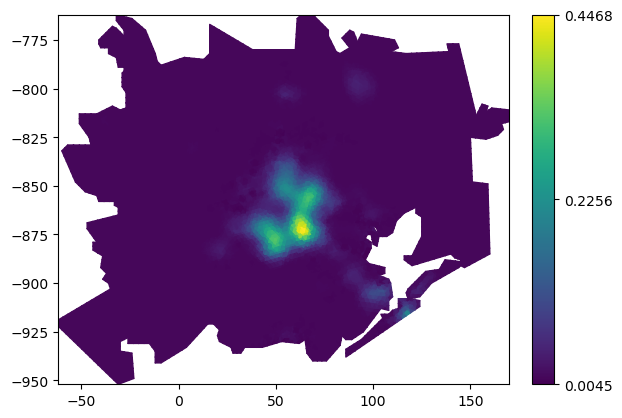

In [46]:
fig, ax = plt.subplots()
plot_mesh(ϕB, mesh, ax=ax)

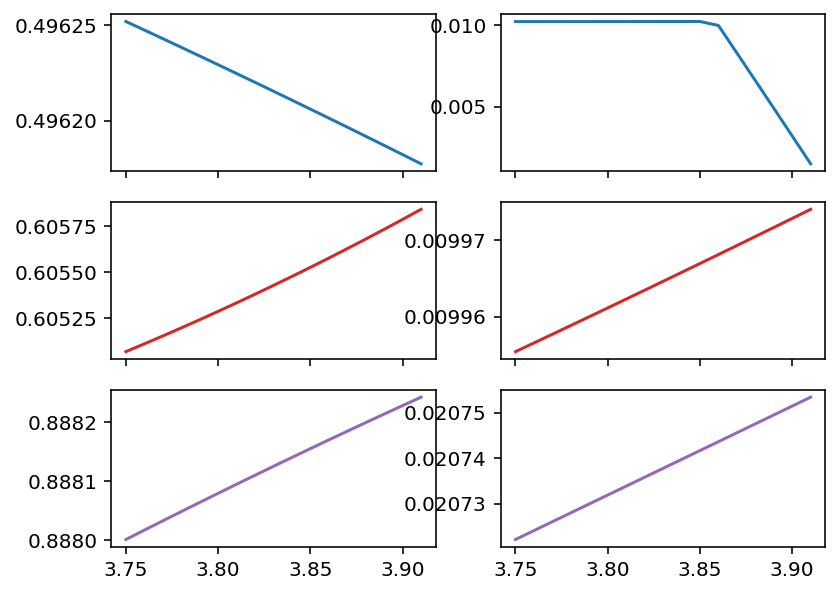

In [20]:
fig, ax = plt.subplots(3, 2, dpi=144, sharex=True)
ax[0, 0].plot(t, phiwb_minmax[:, 1], color="C0")
ax[1, 0].plot(t, phiwb_minmax[:, 3], color="C3")
ax[2, 0].plot(t, phi0_minmax[:, 1], color="C4")

ax[0, 1].plot(t, phiwb_minmax[:, 0], color="C0")
ax[1, 1].plot(t, phiwb_minmax[:, 2], color="C3")
ax[2, 1].plot(t, phi0_minmax[:, 0], color="C4")

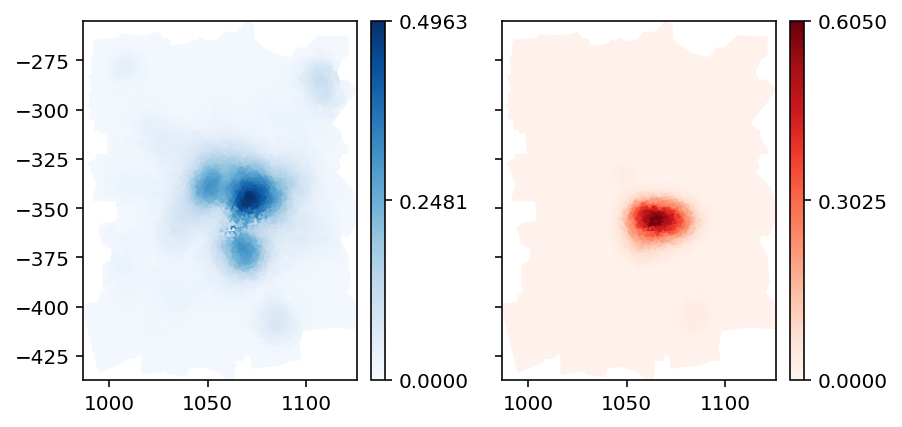

In [90]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
plot_mesh(w, w.mesh, ax[0], cmap=plt.cm.Blues, vmin=0, vmax=w.value.max())
plot_mesh(b, b.mesh, ax[1], cmap=plt.cm.Reds,  vmin=0, vmax=b.value.max())
plt.tight_layout()

In [61]:
import fipy.tools.numerix as nx

In [41]:
ϕ0.value.min()

0.19635376472480393

In [34]:
where = np.where(ϕ0 < 0.4)[0]
vals = ϕ0.value[where]
print(ϕW.value[where])

[0.28355909 0.03429009 0.20716006 0.02743403 0.29089013 0.05662083
 0.14223495 0.21296272 0.18487804 0.03831979 0.10796258 0.15401785
 0.10852318 0.08409068 0.07246701 0.07077692]


In [35]:
np.where?

Call signature:  np.where(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <built-in function where>
Docstring:      
where(condition, [x, y], /)

Return elements chosen from `x` or `y` depending on `condition`.

.. note::
    When only `condition` is provided, this function is a shorthand for
    ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
    preferred, as it behaves correctly for subclasses. The rest of this
    documentation covers only the case where all three arguments are
    provided.

Parameters
----------
condition : array_like, bool
    Where True, yield `x`, otherwise yield `y`.
x, y : array_like
    Values from which to choose. `x`, `y` and `condition` need to be
    broadcastable to some shape.

Returns
-------
out : ndarray
    An array with elements from `x` where `condition` is True, and elements
    from `y` elsewhere.

See Also
--------
choose
nonzero : The function that is called when x and y are omitted

Notes
